In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as splt
from scipy.stats import pearsonr
import seaborn as sns
plt.rcParams['figure.figsize'] = [12, 6]

In [ ]:
#### Question 1)
### Données DPAE

## Lecture du fichier
df = pd.read_excel('dpae-mensuelles-france-entiere.xlsx')
df

,Année,Trimestre,﻿Dernier jour du mois,Durée de contrat,Nature de contrat,DPAE (brut),DPAE (cvs)
0,2000,1,2000-01-31,Contrat de plus d'un mois,c,277127,324376
1,2000,1,2000-01-31,Contrat de plus d'un mois,CDI,279277,226695
2,2000,1,2000-02-29,Contrat de plus d'un mois,CDD de plus d'un mois,222287,321417
3,2000,1,2000-02-29,Contrat de plus d'un mois,CDI,220985,229874
4,2000,1,2000-03-31,Contrat de plus d'un mois,CDD de plus d'un mois,267406,324373
...,...,...,...,...,...,...,...
551,2022,4,2022-12-31,Contrat de plus d'un mois,CDI,303526,426483
552,2023,1,2023-01-31,Contrat de plus d'un mois,CDD de plus d'un mois,366756,384401
553,2023,1,2023-01-31,Contrat de plus d'un mois,CDI,535791,422199
554,2023,1,2023-02-28,Contrat de plus d'un mois,CDD de plus d'un mois,243429,392442


In [ ]:
## Pré-traitement

# On renomme la colonne date et retire les informations superflues (dans le cas de ce sujet)
df2 = df.drop(['Durée de contrat','DPAE (cvs)',], axis = 1)
df2 = df2.rename(columns={'\ufeffDernier jour du mois': 'Date'})
df2['Date'] = pd.to_datetime(df2['Date'])
df2 = df2.sort_values('Date')
df2 = df2.set_index('Date')

# On filtre en fonction de la nature contrat
df2_CDD = df2[df2['Nature de contrat'] == "CDD de plus d'un mois"]
df2_CDD = df2_CDD.drop(['Nature de contrat'], axis = 1)
df2_CDI = df2[df2['Nature de contrat'] == "CDI"]
df2_CDI = df2_CDI.drop(['Nature de contrat'], axis = 1)



<Axes: title={'center': 'Évolution du nombre de contrats CDI'}, xlabel='Date'>

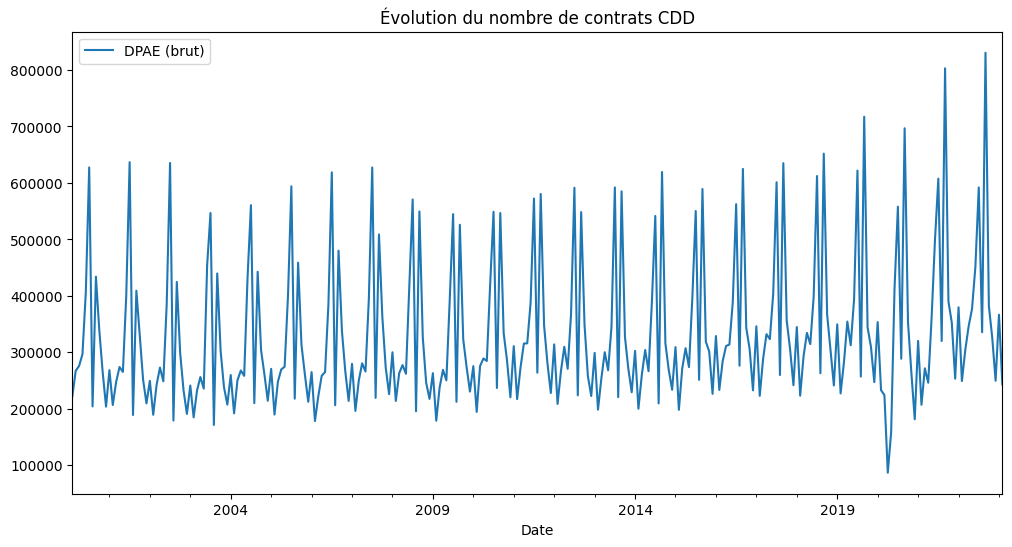

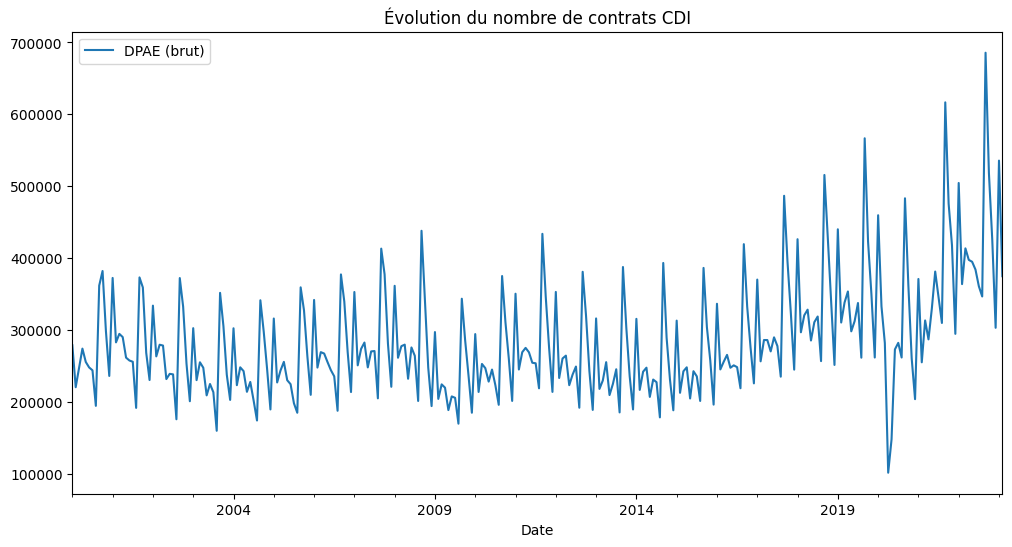

In [ ]:
# Affichage la 1ère série temporelle (CDD)
df2_CDD.plot(x=None, y='DPAE (brut)', title='Évolution du nombre de contrats CDD')
# Affichage la 2ème série temporelle (CDI)
df2_CDI.plot(x=None, y='DPAE (brut)', title='Évolution du nombre de contrats CDI')


<Axes: title={'center': 'DPAE (brut)'}, xlabel='Trimestre'>

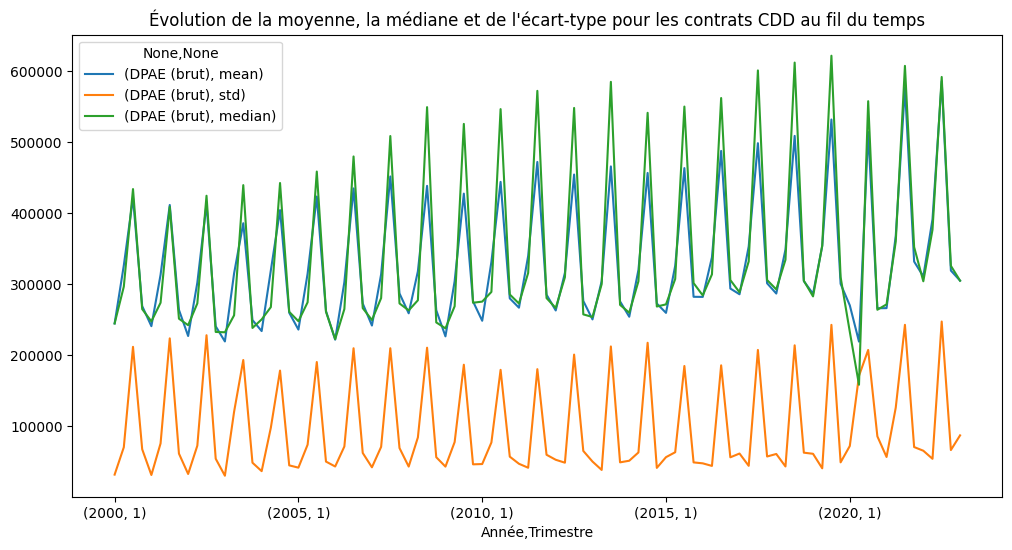

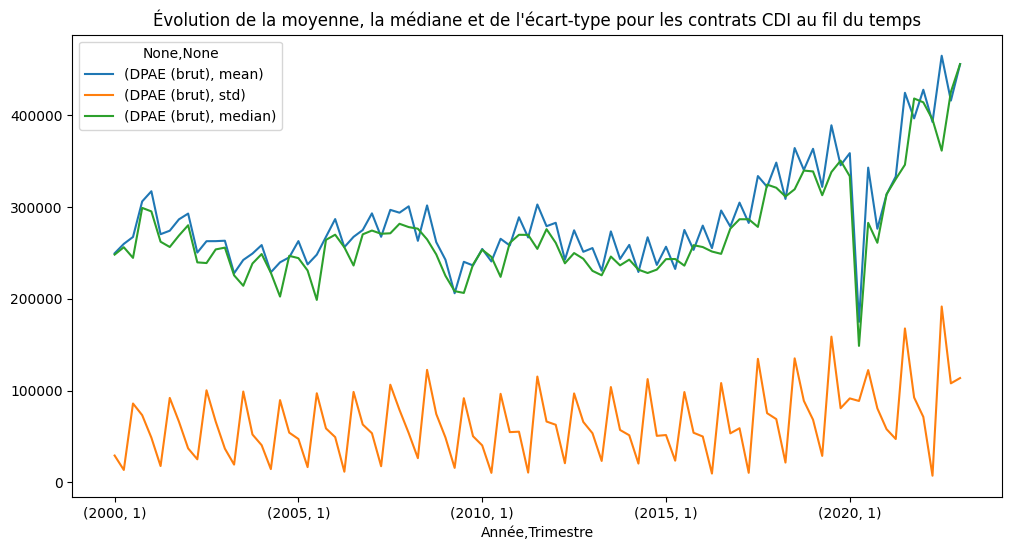

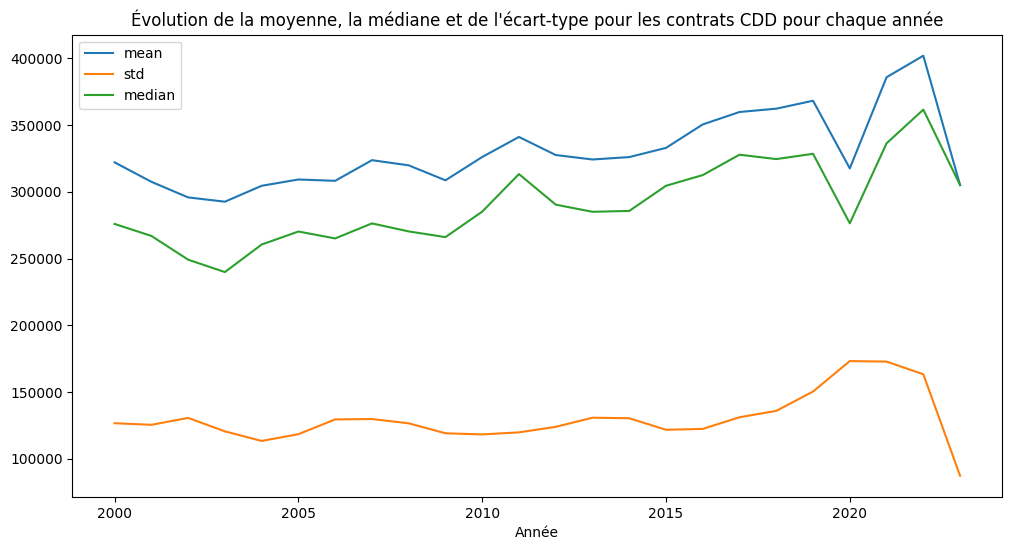

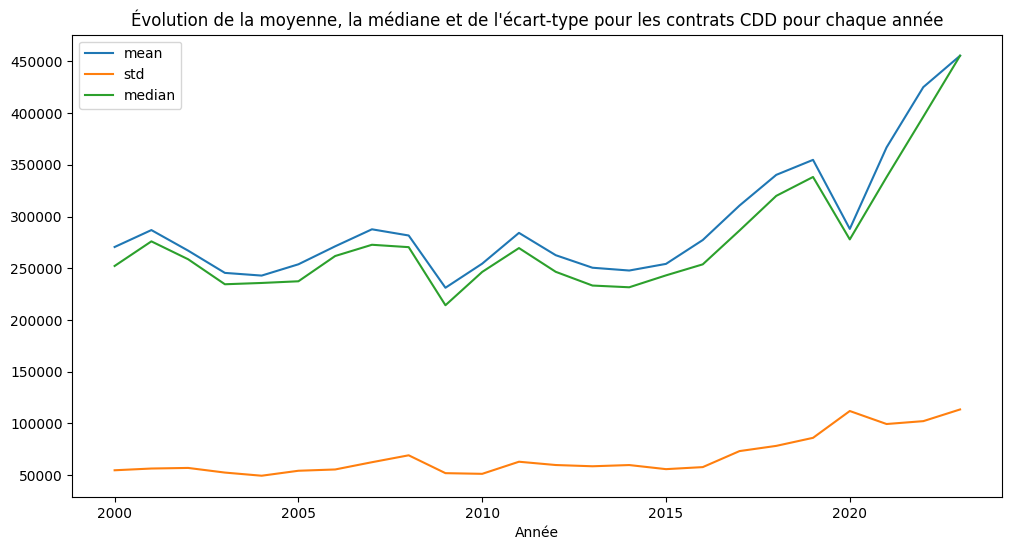

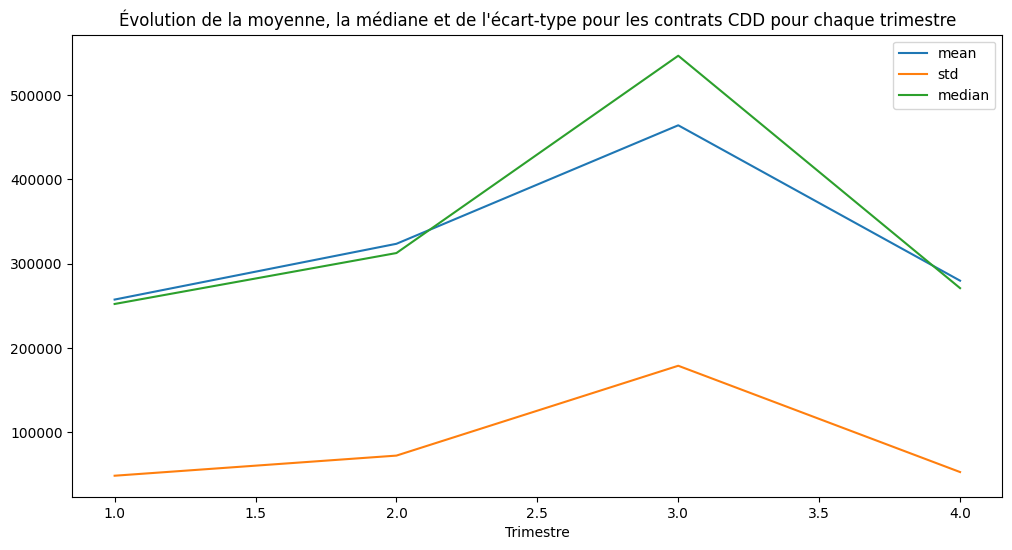

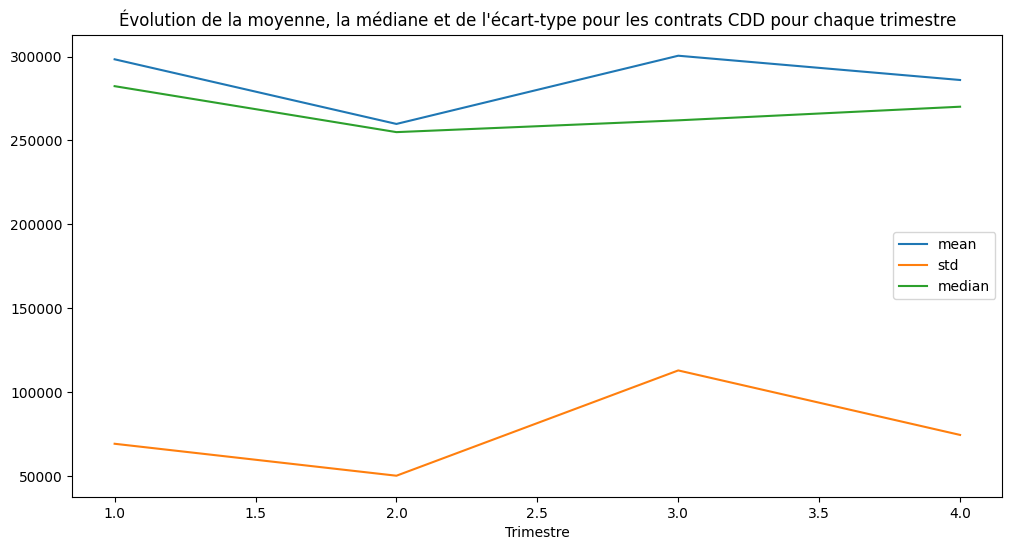

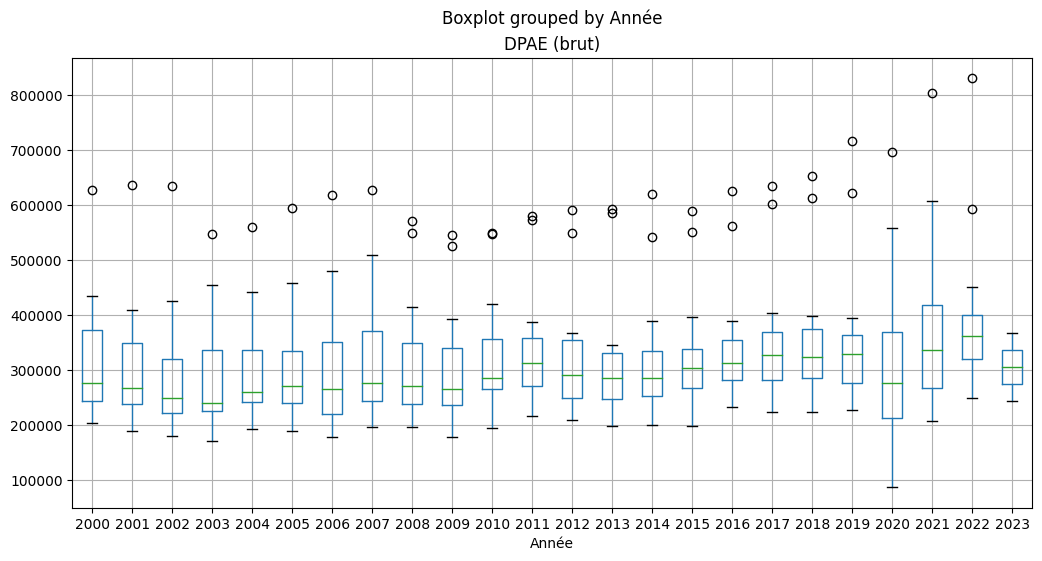

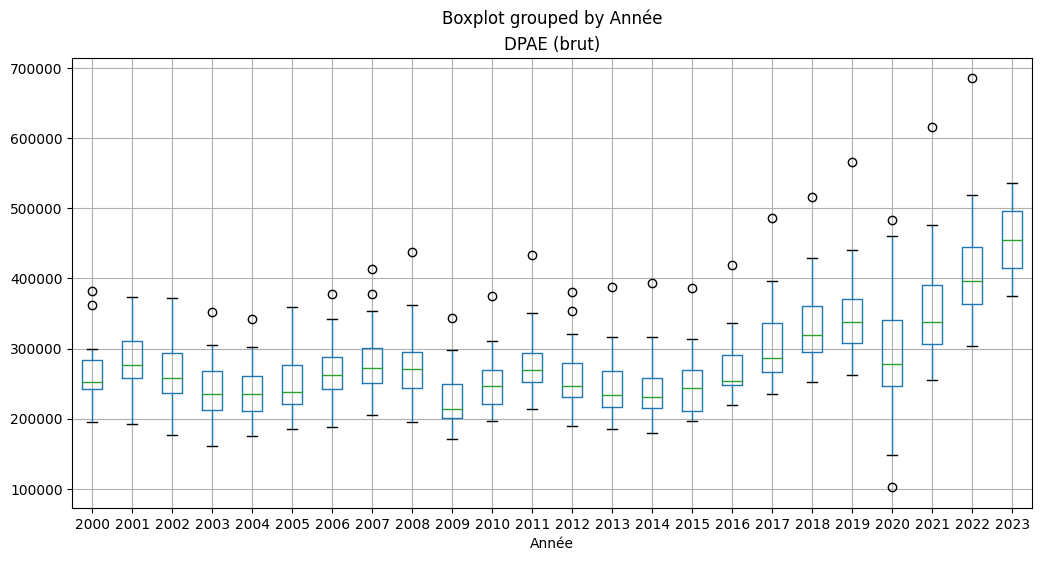

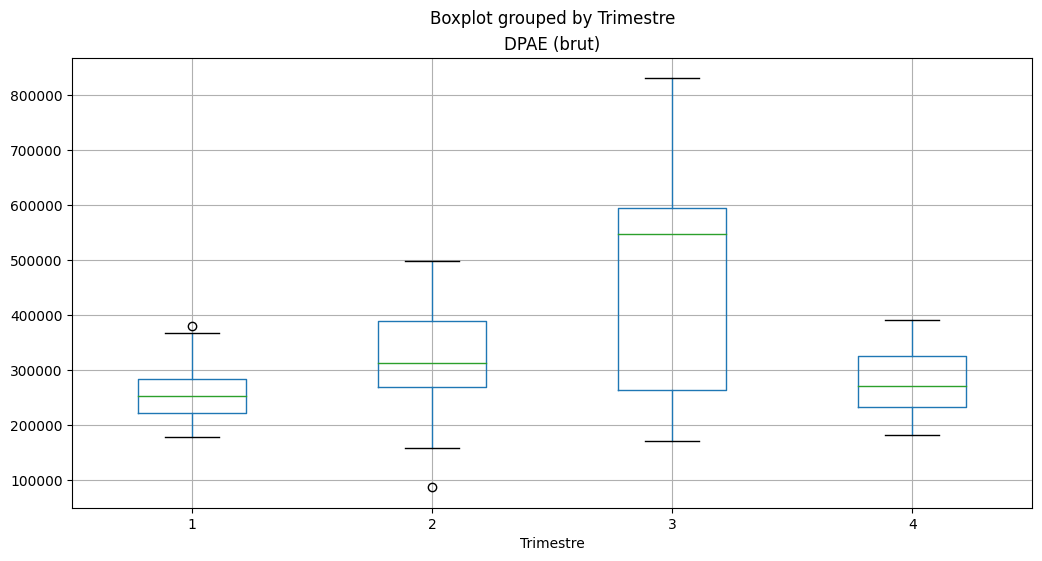

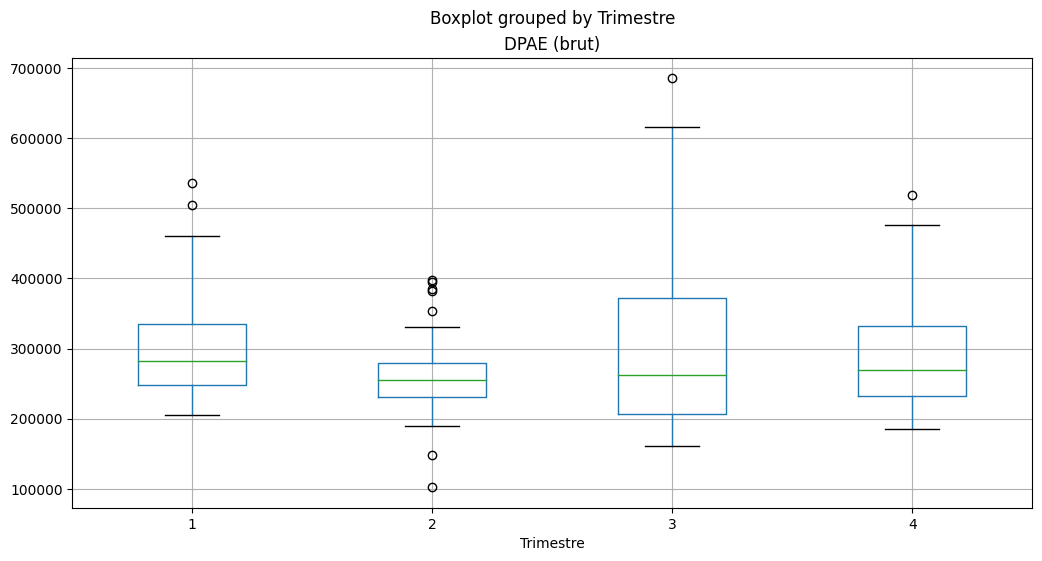

In [ ]:
## Calcul de statistiques

# Evolution des moyennes, medianes et ecart-type au cours du temps Année ; Trimestre
df2_CDD.groupby(['Année', 'Trimestre']).agg(['mean', 'std', 'median']).plot(title= "Évolution de la moyenne, la médiane et de l'écart-type pour les contrats CDD au fil du temps")
df2_CDI.groupby(['Année', 'Trimestre']).agg(['mean', 'std', 'median']).plot(title= "Évolution de la moyenne, la médiane et de l'écart-type pour les contrats CDI au fil du temps")

# Evolutions des moyennes, medianes et ecart-type pour chaque année
df2_CDD.groupby(['Année']).agg(['mean', 'std', 'median']).plot(title= "Évolution de la moyenne, la médiane et de l'écart-type pour les contrats CDD pour chaque année",x = None, y = 'DPAE (brut)')
df2_CDI.groupby(['Année']).agg(['mean', 'std', 'median']).plot(title= "Évolution de la moyenne, la médiane et de l'écart-type pour les contrats CDD pour chaque année",x = None, y = 'DPAE (brut)')

# Evolutions des moyennes, medianes et ecart-type pour chaque trimestre
df2_CDD.groupby(['Trimestre']).agg(['mean', 'std', 'median']).plot(title= "Évolution de la moyenne, la médiane et de l'écart-type pour les contrats CDD pour chaque trimestre",x = None, y = 'DPAE (brut)')
df2_CDI.groupby(['Trimestre']).agg(['mean', 'std', 'median']).plot(title= "Évolution de la moyenne, la médiane et de l'écart-type pour les contrats CDD pour chaque trimestre",x = None, y = 'DPAE (brut)')

# Boîtes à moustache par année
df2_CDD.boxplot(column='DPAE (brut)', by='Année')
df2_CDI.boxplot(column='DPAE (brut)', by='Année')

# Boîtes à moustache par trimestre
df2_CDD.boxplot(column='DPAE (brut)', by='Trimestre')
df2_CDI.boxplot(column='DPAE (brut)', by='Trimestre')

# Vis à vis du graphique témoignant de l'évolution du nombre de CDD, on constate une périodicité, une tendance constante et une saisonalité additive.
# Tandis que pour le graphique témoignant de l'évolution du nombre de CDI, on constate les mêmes traits que pour la graphique précédent, jusqu'à
# l'année 2014, ou la tendance devient exponentielle & la saisonalité multiplicative.


In [ ]:
### Données ESSA
## Lecture du Fichier
df_ESSA_BRUT = pd.read_excel('famille_EMPLOI-SALARIE-TRIM-NATIONAL_09032023.xlsx')

In [ ]:
## Pré-Traitement
df_ESSA = df_ESSA_BRUT.replace('(O)', np.nan, regex = False)
df_ESSA = df_ESSA.drop(['Dernière mise à jour', 'idBank', 'Période'], axis = 1).T
df_ESSA = df_ESSA.rename(index = {'Libellé': 'Date'})
df_ESSA = df_ESSA.set_axis(df_ESSA.loc[df_ESSA.index[0], :], axis=1)
df_ESSA = df_ESSA.drop(['Date'], axis = 0)

<Axes: title={'center': "Évolution du nombre d'emplois salariés trimestriels"}>

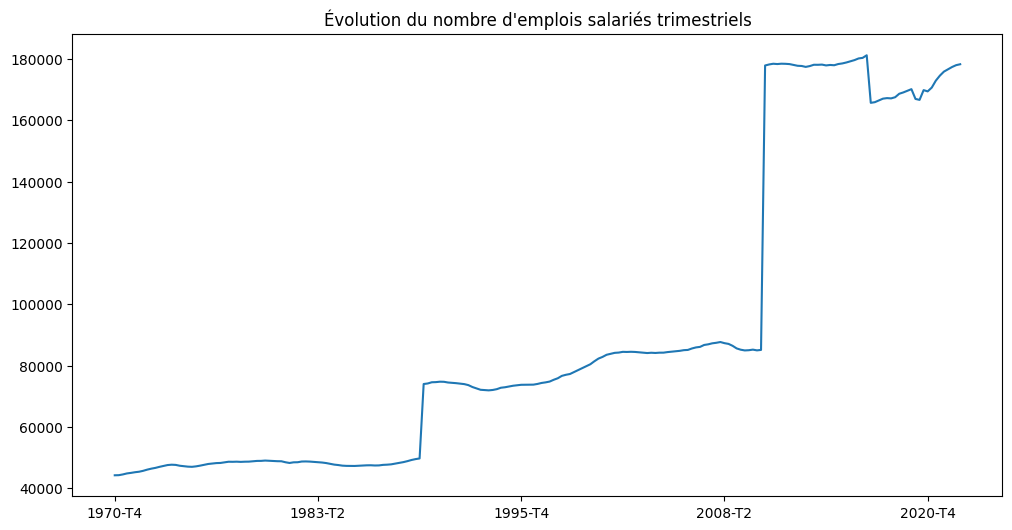

In [ ]:
## Affichage de la série temporelle qui somme les données
df_ESSA_sumseries = df_ESSA['Somme des secteurs'] = df_ESSA.sum(axis = 1)
df_ESSA_sumseries.plot(x = None, y = 'Somme des secteurs', title = "Évolution du nombre d'emplois salariés trimestriels")

# On remarque 2 pics distincts, le premier en 1989 et le second en 2012. Les deux s'expliquent par l'apparition de différents secteurs à ces années là
# comme l'"Industrie chimique" ou encore "Production et distribution d'éléctricité, de gaz, de vapeur et d'air conditionné".
# De manière générale, on constate une tendance croissante.


<Axes: >

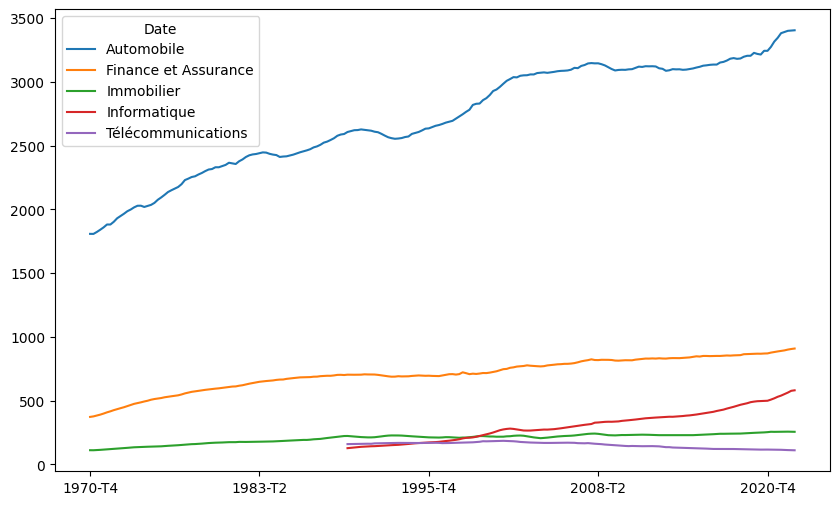

In [ ]:
## On garde uniquement 5 secteurs : 
# Emplois salariés trimestriels - Commerce, réparation d'automobiles et de motocycles - A17 : GZ - CVS
# Emplois salariés trimestriels - Activités financières et d'assurance - A17 : KZ - CVS
# Emplois salariés trimestriels - Activités immobilières - A17 : LZ - CVS
# Emplois salariés trimestriels - Activités informatiques et services d'information - A38 : JC - CVS
# Emplois salariés trimestriels - Télécommunications - A38 : JB - CVS

df_ESSA_five_series = df_ESSA.loc[:, ["Emplois salariés trimestriels - Commerce, réparation d'automobiles et de motocycles - A17 : GZ - CVS", "Emplois salariés trimestriels - Activités financières et d'assurance - A17 : KZ - CVS" , "Emplois salariés trimestriels - Activités immobilières - A17 : LZ - CVS" , "Emplois salariés trimestriels - Activités informatiques et services d'information - A38 : JC - CVS" , "Emplois salariés trimestriels - Télécommunications - A38 : JB - CVS"]]
df_ESSA_five_series = df_ESSA_five_series.rename(columns = {"Emplois salariés trimestriels - Commerce, réparation d'automobiles et de motocycles - A17 : GZ - CVS" : "Automobile" , "Emplois salariés trimestriels - Activités financières et d'assurance - A17 : KZ - CVS" : "Finance et Assurance", "Emplois salariés trimestriels - Activités immobilières - A17 : LZ - CVS" : "Immobilier", "Emplois salariés trimestriels - Activités informatiques et services d'information - A38 : JC - CVS" : "Informatique" , "Emplois salariés trimestriels - Télécommunications - A38 : JB - CVS" : "Télécommunications"})
df_ESSA_five_series.plot(x = None, figsize =(10,6))

##### A rediger

/usr/local/lib/python3.9/dist-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.9/dist-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.9/dist-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.9/dist-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.9/dist-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.9/dist-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/p

<Axes: title={'center': "Évolution de la moyenne, la médiane et de l'écart-type pour le secteur des Télécommunications"}, xlabel='Année'>

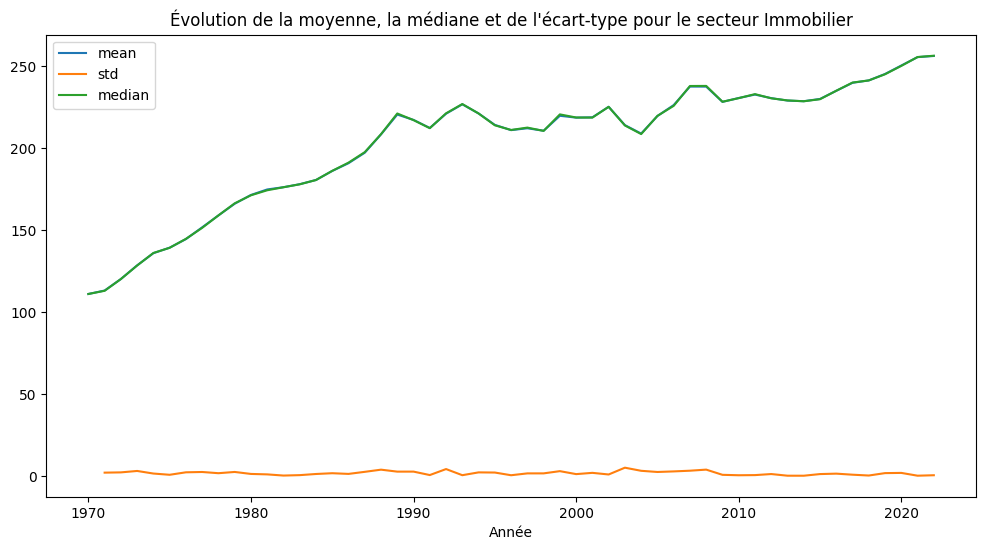

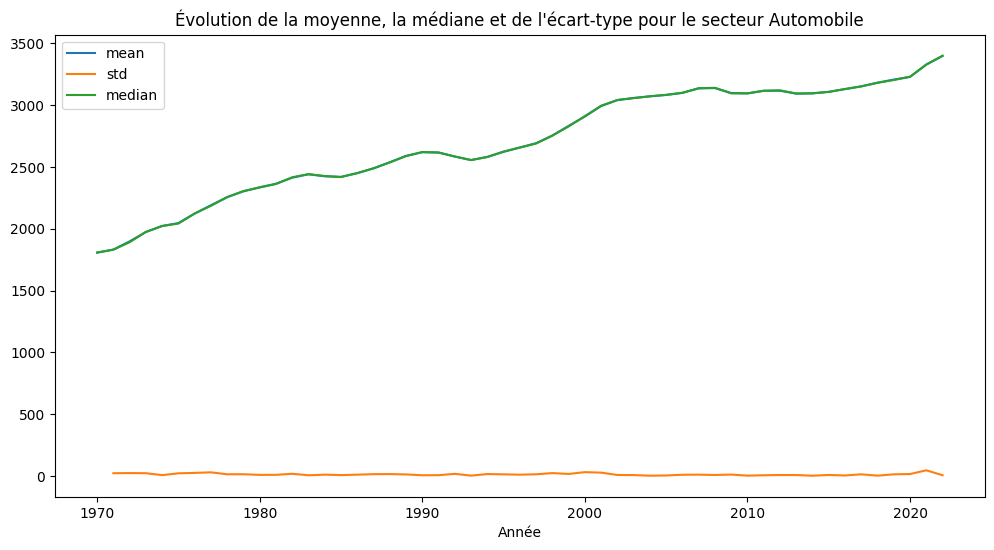

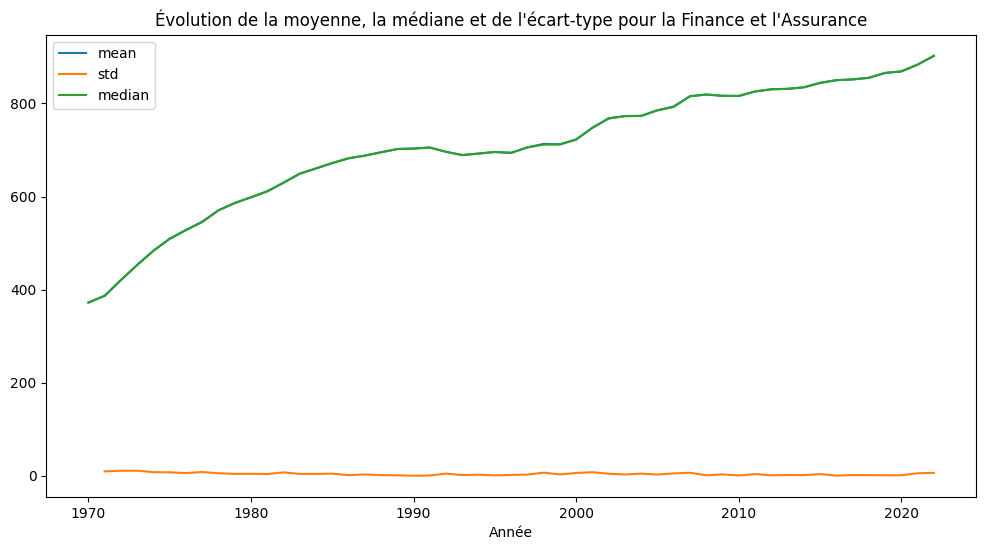

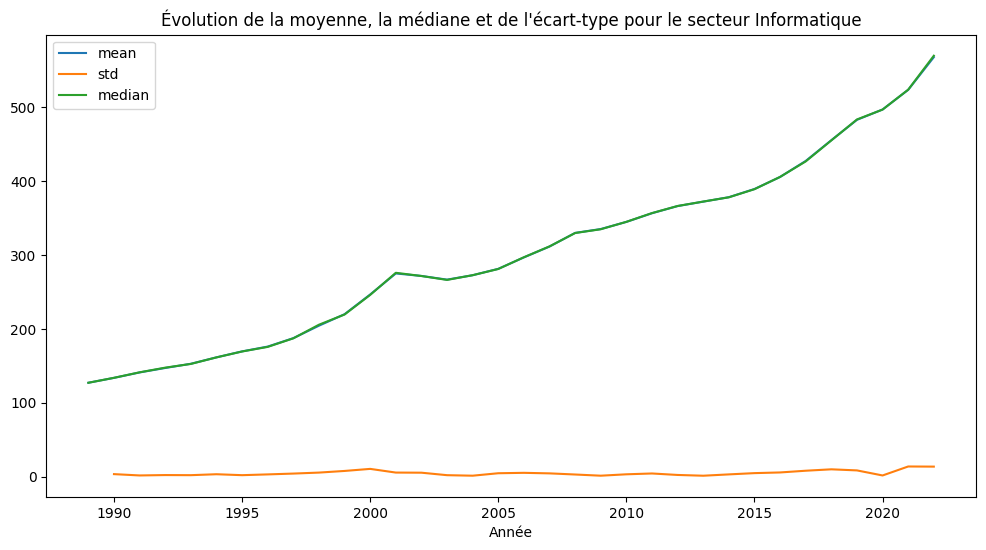

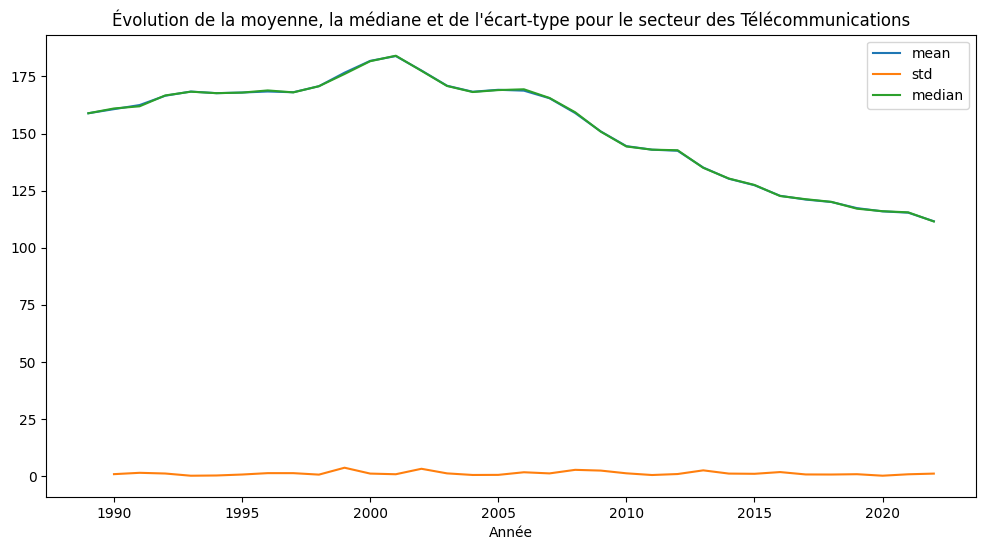

In [ ]:
## Calcul de statistiques
# Création des colonnes Année et Trimestre
df_ESSA_five_series['Année'] = df_ESSA_five_series.index.str.split('-').str[0].astype(int)
df_ESSA_five_series['Trimestre'] = df_ESSA_five_series.index.str.split('-').str[1].str.replace('T', '').astype(int)

df_ESSA_five_series.groupby(['Année']).agg(['mean', 'std', 'median']).plot(x = None, y = 'Immobilier' ,title= "Évolution de la moyenne, la médiane et de l'écart-type pour le secteur Immobilier")
df_ESSA_five_series.groupby(['Année']).agg(['mean', 'std', 'median']).plot(x = None, y = 'Automobile' ,title= "Évolution de la moyenne, la médiane et de l'écart-type pour le secteur Automobile")
df_ESSA_five_series.groupby(['Année']).agg(['mean', 'std', 'median']).plot(x = None, y = 'Finance et Assurance' ,title= "Évolution de la moyenne, la médiane et de l'écart-type pour la Finance et l'Assurance")
df_ESSA_five_series.groupby(['Année']).agg(['mean', 'std', 'median']).plot(x = None, y = 'Informatique' ,title= "Évolution de la moyenne, la médiane et de l'écart-type pour le secteur Informatique")
df_ESSA_five_series.groupby(['Année']).agg(['mean', 'std', 'median']).plot(x = None, y = 'Télécommunications' ,title= "Évolution de la moyenne, la médiane et de l'écart-type pour le secteur des Télécommunications")

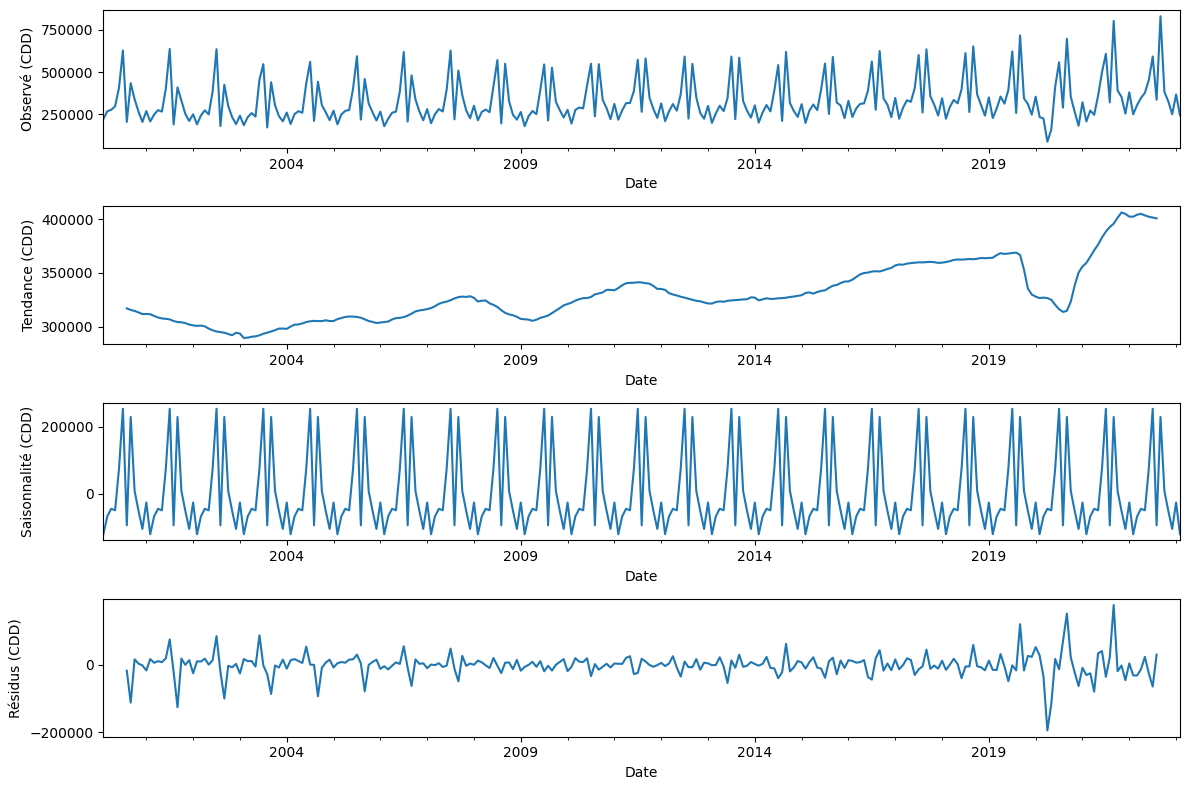

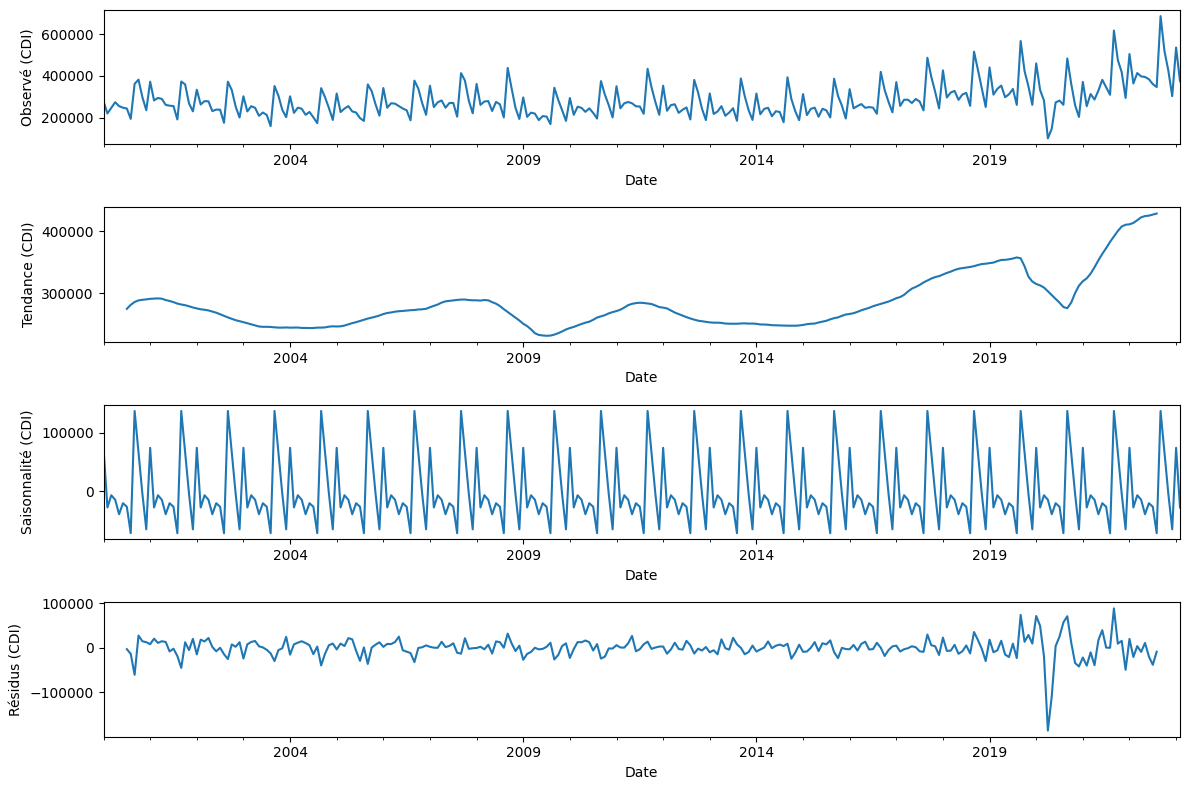

In [ ]:
#### Question 2)
### Saisonnalité des CDD et CDI
decomposition_CDD = seasonal_decompose(df2_CDD['DPAE (brut)'], period=12)
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(12,8))
decomposition_CDD.observed.plot(ax=ax1, legend=False)
ax1.set_ylabel('Observé (CDD)')
decomposition_CDD.trend.plot(ax=ax2, legend=False)
ax2.set_ylabel('Tendance (CDD)')
decomposition_CDD.seasonal.plot(ax=ax3, legend=False)
ax3.set_ylabel('Saisonnalité (CDD)')
decomposition_CDD.resid.plot(ax=ax4, legend=False)
ax4.set_ylabel('Résidus (CDD)')
plt.tight_layout()

decomposition_CDI = seasonal_decompose(df2_CDI['DPAE (brut)'], period=12)
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(12,8))
decomposition_CDI.observed.plot(ax=ax1, legend=False)
ax1.set_ylabel('Observé (CDI)')
decomposition_CDI.trend.plot(ax=ax2, legend=False)
ax2.set_ylabel('Tendance (CDI)')
decomposition_CDI.seasonal.plot(ax=ax3, legend=False)
ax3.set_ylabel('Saisonnalité (CDI)')
decomposition_CDI.resid.plot(ax=ax4, legend=False)
ax4.set_ylabel('Résidus (CDI)')
plt.tight_layout()

<Axes: xlabel='Trimestre'>

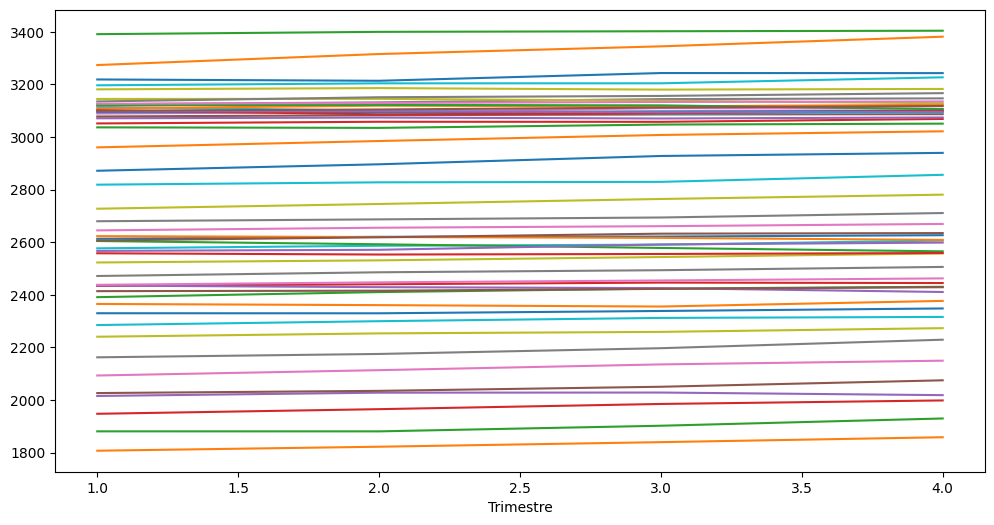

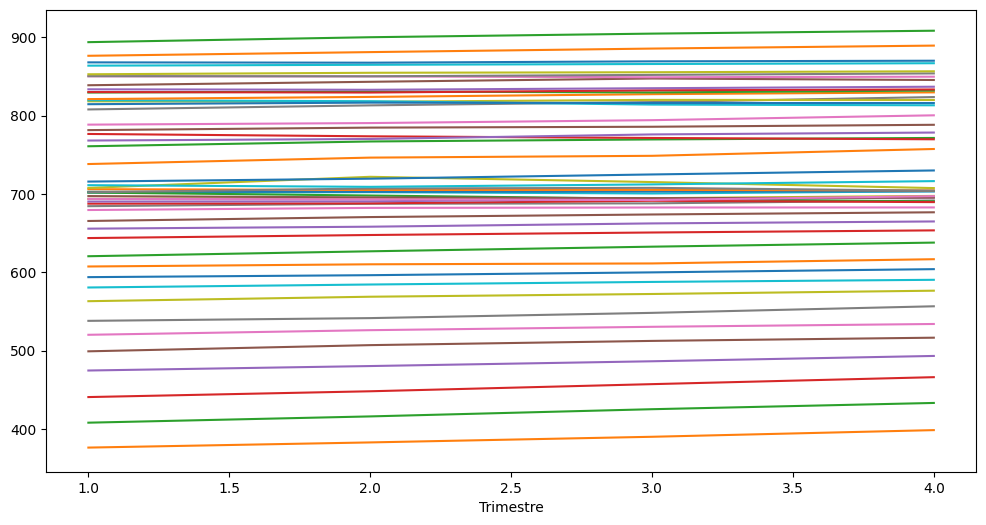

In [ ]:
### Saisonnalité des secteurs sur ESSA
df_ESSA_five_series_Automobile = df_ESSA_five_series.loc[: , ['Automobile', 'Année', 'Trimestre']]
df_ESSA_five_series_Automobile.set_index("Année")
pivot_table = pd.pivot_table(df_ESSA_five_series_Automobile, index = ['Trimestre'], columns = ['Année'])
pivot_table.plot(legend = None)

df_ESSA_five_series_FA = df_ESSA_five_series.loc[: , ['Finance et Assurance', 'Année', 'Trimestre']]
df_ESSA_five_series_FA.set_index("Année")
pivot_table = pd.pivot_table(df_ESSA_five_series_FA, index = ['Trimestre'], columns = ['Année'])
pivot_table.plot(legend = None)

## Afin d'économiser de l'espace et pouvoir effectuer le dépôt sur campus, on n'affiche pas ces trois derniers graphes

# df_ESSA_five_series_Informatique = df_ESSA_five_series.loc[: , ['Informatique', 'Année', 'Trimestre']]
# df_ESSA_five_series_Informatique.set_index("Année")
# pivot_table = pd.pivot_table(df_ESSA_five_series_Informatique, index = ['Trimestre'], columns = ['Année'])
# pivot_table.plot(legend = None)

# df_ESSA_five_series_Immobilier = df_ESSA_five_series.loc[: , ['Immobilier', 'Année', 'Trimestre']]
# df_ESSA_five_series_Immobilier.set_index("Année")
# pivot_table = pd.pivot_table(df_ESSA_five_series_Immobilier, index = ['Trimestre'], columns = ['Année'])
# pivot_table.plot(legend = None)

# df_ESSA_five_series_Télécommunications = df_ESSA_five_series.loc[: , ['Télécommunications', 'Année', 'Trimestre']]
# df_ESSA_five_series_Télécommunications.set_index("Année")
# pivot_table = pd.pivot_table(df_ESSA_five_series_Télécommunications, index = ['Trimestre'], columns = ['Année'])
# pivot_table.plot(legend = None)




<ipython-input-118-6d3a6d330019>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ESSA_five_series_2000['Date'] = df_ESSA_five_series_2000.apply(lambda row: str(row['Année']) + '-Q' + str(row['Trimestre']), axis=1)


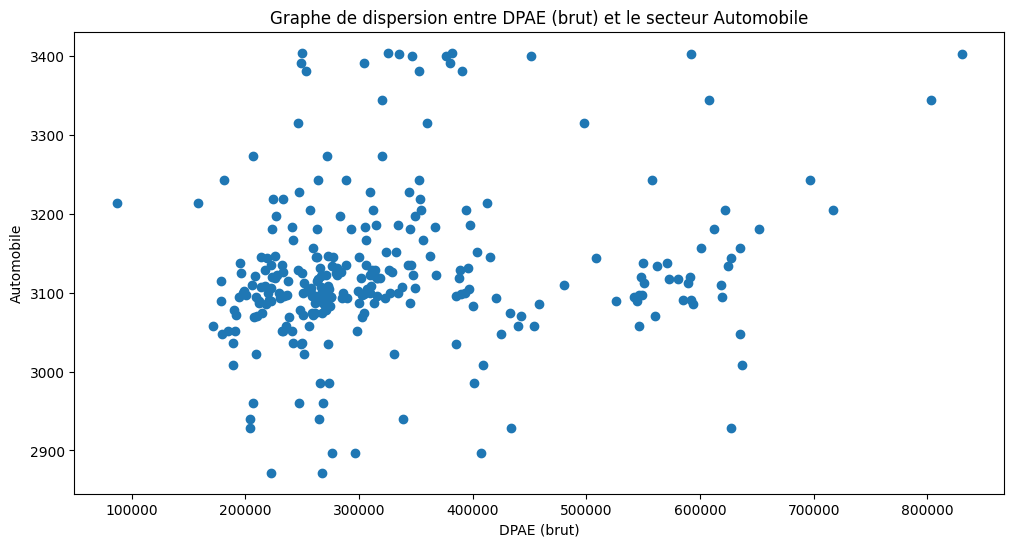

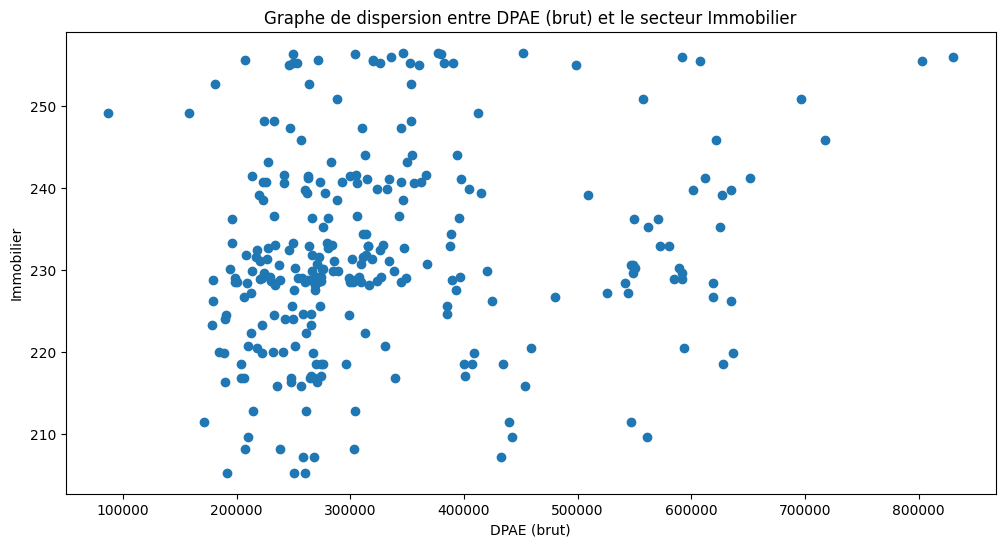

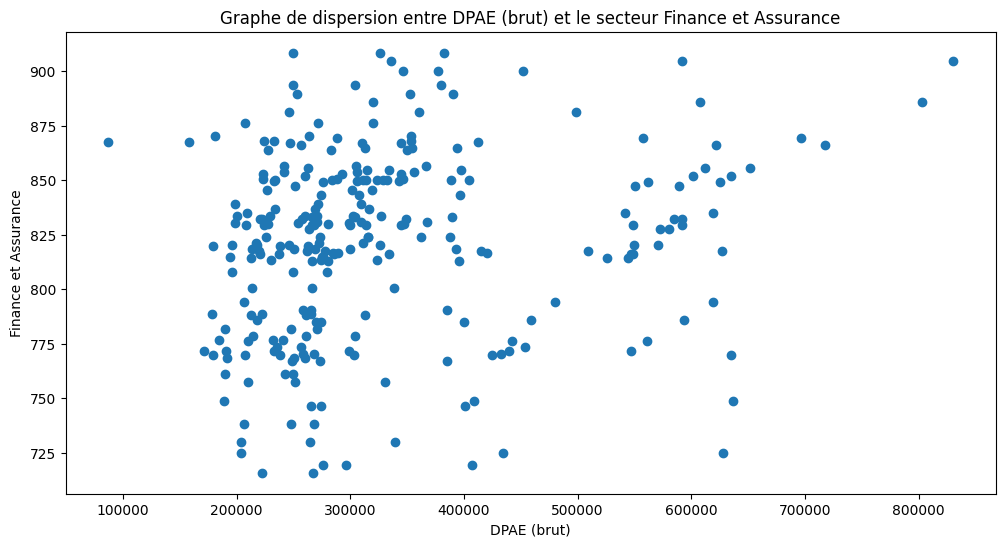

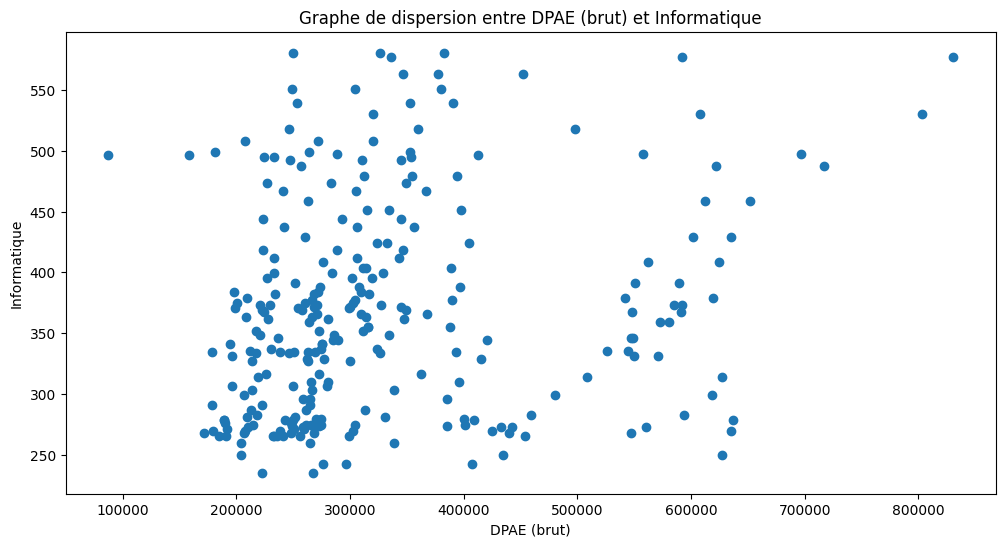

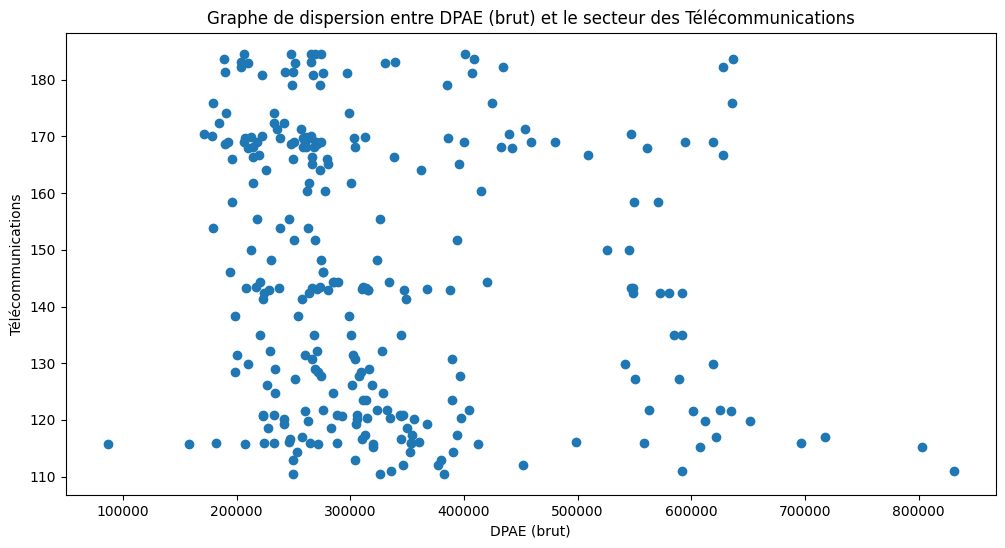

In [ ]:
## Corrélation
#Les séries CDI et CDD étant relativement proches, on calcule uniquement la corrélation sur la série des CDD

df_ESSA_five_series_2000 = df_ESSA_five_series.loc[(df_ESSA_five_series['Année'] >= 2000) & (df_ESSA_five_series['Année'] <= 2022)]
df_ESSA_five_series_2000['Date'] = df_ESSA_five_series_2000.apply(lambda row: str(row['Année']) + '-Q' + str(row['Trimestre']), axis=1)
df_ESSA_five_series_2000_corr = df_ESSA_five_series_2000.set_index('Date').drop(['Année', 'Trimestre'], axis = 1)

df2_CDD['Date'] = df2_CDD.apply(lambda row: str(row['Année']) + '-Q' + str(row['Trimestre']), axis=1)
df2_CDD_corr = df2_CDD.loc[(df2_CDD['Année'] <= 2022)]
df2_CDD_corr = df2_CDD_corr.set_index('Date').drop(['Année', 'Trimestre'], axis = 1)



# Fusionner les deux DataFrames
df_merged = pd.merge(df2_CDD_corr, df_ESSA_five_series_2000_corr, left_index=True, right_index=True)

# Calculer la corrélation pour le secteur Automobile
correlation, p_value = pearsonr(df_merged['DPAE (brut)'], df_merged['Automobile'])
plt.scatter(df_merged['DPAE (brut)'], df_merged['Automobile'])
plt.xlabel('DPAE (brut)')
plt.ylabel('Automobile')
plt.title('Graphe de dispersion entre DPAE (brut) et le secteur Automobile')
plt.show()

# Calculer la corrélation pour le secteur Immobilier
correlation, p_value = pearsonr(df_merged['DPAE (brut)'], df_merged['Immobilier'])
plt.scatter(df_merged['DPAE (brut)'], df_merged['Immobilier'])
plt.xlabel('DPAE (brut)')
plt.ylabel('Immobilier')
plt.title('Graphe de dispersion entre DPAE (brut) et le secteur Immobilier')
plt.show()

# Calculer la corrélation pour le secteur Finance et Assurance
correlation, p_value = pearsonr(df_merged['DPAE (brut)'], df_merged['Finance et Assurance'])
plt.scatter(df_merged['DPAE (brut)'], df_merged['Finance et Assurance'])
plt.xlabel('DPAE (brut)')
plt.ylabel('Finance et Assurance')
plt.title('Graphe de dispersion entre DPAE (brut) et le secteur Finance et Assurance')
plt.show()

# Calculer la corrélation pour le secteur Informatique
correlation, p_value = pearsonr(df_merged['DPAE (brut)'], df_merged['Informatique'])
plt.scatter(df_merged['DPAE (brut)'], df_merged['Informatique'])
plt.xlabel('DPAE (brut)')
plt.ylabel('Informatique')
plt.title('Graphe de dispersion entre DPAE (brut) et Informatique')
plt.show()

# Calculer la corrélation pour le secteur des Télécommunications
correlation, p_value = pearsonr(df_merged['DPAE (brut)'], df_merged['Télécommunications'])
plt.scatter(df_merged['DPAE (brut)'], df_merged['Télécommunications'])
plt.xlabel('DPAE (brut)')
plt.ylabel('Télécommunications')
plt.title('Graphe de dispersion entre DPAE (brut) et le secteur des Télécommunications')
plt.show()


In [ ]:
# A priori, on ne constate aucune corrélation avec ces graphes de dispersion entre les 5 secteurs séléctionnées & les contrats CDD.

In [ ]:
### Question 3) et Question 4)

from statsmodels.tsa.api import SimpleExpSmoothing

df2_CDI_prediction = df2_CDI.drop(['Année', 'Trimestre'], axis = 1)
df2_CDD_prediction = df2_CDD.drop(['Année', 'Trimestre'], axis = 1)


df_ESSA_five_series['Date'] = df_ESSA_five_series.apply(lambda row: str(row['Année']) + '-Q' + str(row['Trimestre']), axis=1)
df_ESSA_five_series_prediction = df_ESSA_five_series.set_index('Date').drop(['Année', 'Trimestre'], axis = 1)


# DPAE

# On spécifie la colonne "DPAE (brut)" comme colonne de données
data = df2_CDI_prediction['DPAE (brut)']
data2 = df2_CDD_prediction['DPAE (brut)']

# On scinde nos données en ensembles d'apprentissage et de test
train_data = data[:-12] 
test_data = data[-12:] # les 4 derniers trimestres comme test

train_data2 = data2[:-12]
test_data2 = data2[-12:]

# Lissage exponentiel simple
model = SimpleExpSmoothing(train_data).fit()
model2 = SimpleExpSmoothing(train_data2).fit()

# Prédicition des valeurs pour l'ensemble test
predictions = model.predict(start=test_data.index[0], end=test_data.index[-1])
predictions2 = model2.predict(start=test_data2.index[0], end=test_data2.index[-1])

# Calculer l'erreur absolue moyenne (pour la question 4)
mae = (test_data - predictions).abs().mean()
mae2 = (test_data - predictions).abs().mean()

# Afficher les prévisions et l'erreur absolue moyenne
print("Prévisions : ", predictions)
print("MAE :", mae)

print("Prévisions : ", predictions2)
print("MAE :", mae2)


#
# ESSA
#


# On spécifie la colonne "Automobile" et "Immobilier" comme colonne de données
df_ESSA_five_series_prediction['Automobile'] = pd.to_numeric(df_ESSA_five_series_prediction['Automobile'], errors='coerce')
data = df_ESSA_five_series_prediction['Automobile']
df_ESSA_five_series_prediction['Immobilier'] = pd.to_numeric(df_ESSA_five_series_prediction['Immobilier'], errors='coerce')
data2 = df_ESSA_five_series_prediction['Immobilier']

# On scinde nos données en ensembles d'apprentissage et de test
train_data = data[:-12] 
test_data = data[-12:] # les 4 derniers trimestres comme test

train_data2 = data2[:-12]
test_data2 = data2[-12:]

# Lissage exponentiel simple
model = SimpleExpSmoothing(train_data).fit()
model2 = SimpleExpSmoothing(train_data2).fit()

# Prédicition des valeurs pour l'ensemble test
predictions = model.predict(start=test_data.index[0], end=test_data.index[-1])
predictions2 = model2.predict(start=test_data2.index[0], end=test_data2.index[-1])

# On calcule l'erreur absolue moyenne (pour la question 4)
mae = (test_data - predictions).abs().mean()
mae2 = (test_data - predictions).abs().mean()

# on affiche les prévisions et l'erreur absolue moyenne
print("Prévisions : ", predictions)
print("MAE :", mae)

print("Prévisions : \n", predictions2)
print("MAE :", mae2)

Prévisions :  2022-03-31    366421.940537
2022-04-30    366421.940537
2022-05-31    366421.940537
2022-06-30    366421.940537
2022-07-31    366421.940537
2022-08-31    366421.940537
2022-09-30    366421.940537
2022-10-31    366421.940537
2022-11-30    366421.940537
2022-12-31    366421.940537
2023-01-31    366421.940537
2023-02-28    366421.940537
Freq: M, dtype: float64
MAE : 76787.11306464566
Prévisions :  2022-03-31    359760.270984
2022-04-30    359760.270984
2022-05-31    359760.270984
2022-06-30    359760.270984
2022-07-31    359760.270984
2022-08-31    359760.270984
2022-09-30    359760.270984
2022-10-31    359760.270984
2022-11-30    359760.270984
2022-12-31    359760.270984
2023-01-31    359760.270984
2023-02-28    359760.270984
Freq: M, dtype: float64
MAE : 76787.11306464566
Prévisions :  2020-01-01    3226.885997
2020-04-01    3226.885997
2020-07-01    3226.885997
2020-10-01    3226.885997
2021-01-01    3226.885997
2021-04-01    3226.885997
2021-07-01    3226.885997
2021-10-

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/t

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  222
Model:               SARIMAX(2, 0, 4)   Log Likelihood               -2727.883
Date:                Tue, 11 Apr 2023   AIC                           5469.766
Time:                        00:49:38   BIC                           5493.585
Sample:                    01-31-2000   HQIC                          5479.383
                         - 06-30-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1      -5.672e-05      0.003     -0.021      0.984      -0.005       0.005
ar.L2          0.9993      0.003    380.902      0.000       0.994       1.004
ma.L1          0.4654      0.122      3.820      0.0

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


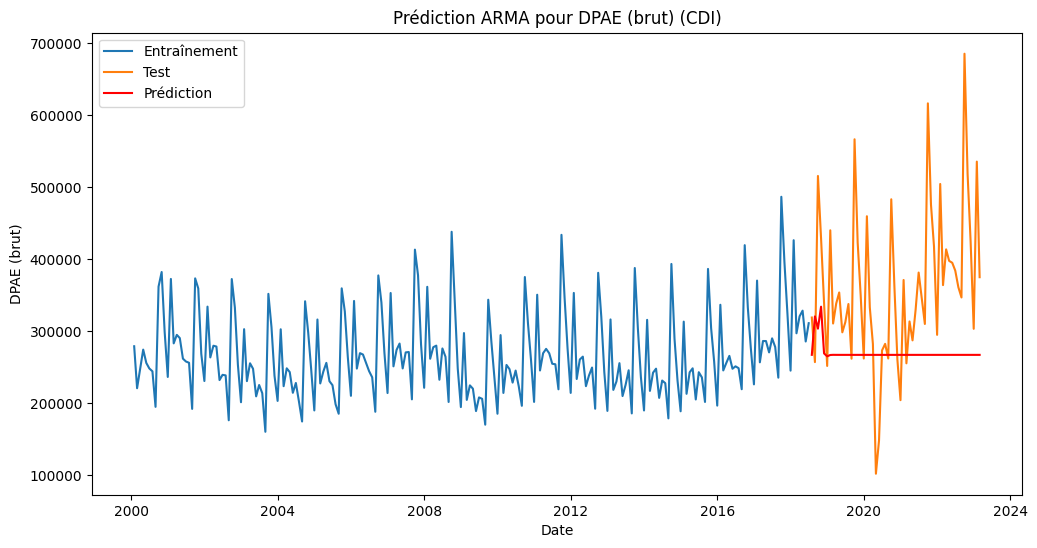

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  221
Model:               SARIMAX(5, 0, 1)   Log Likelihood               -2833.420
Date:                Tue, 11 Apr 2023   AIC                           5682.839
Time:                        00:49:47   BIC                           5710.024
Sample:                    02-29-2000   HQIC                          5693.816
                         - 06-30-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   4.323e+05   6.09e+04      7.102      0.000    3.13e+05    5.52e+05
ar.L1         -0.0125      0.124     -0.101      0.920      -0.256       0.231
ar.L2          0.3423      0.063      5.431      0.0

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


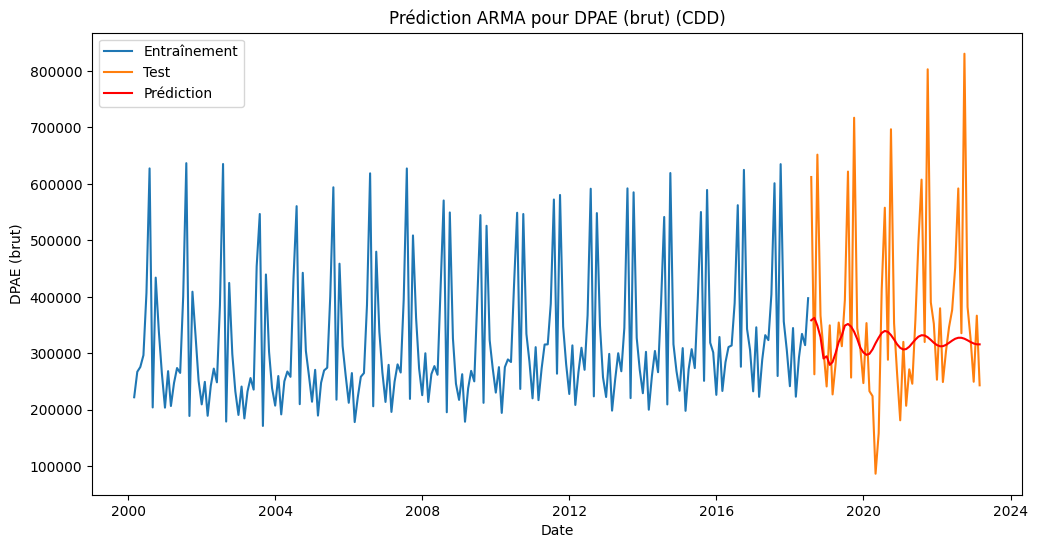

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  167
Model:               SARIMAX(0, 2, 1)   Log Likelihood                -572.006
Date:                Tue, 11 Apr 2023   AIC                           1148.011
Time:                        00:49:49   BIC                           1154.223
Sample:                    10-01-1970   HQIC                          1150.533
                         - 04-01-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5417      0.058     -9.397      0.000      -0.655      -0.429
sigma2        59.9555      6.565      9.132      0.000      47.087      72.824
Ljung-Box (L1) (Q):                   0.01   Jarque-

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


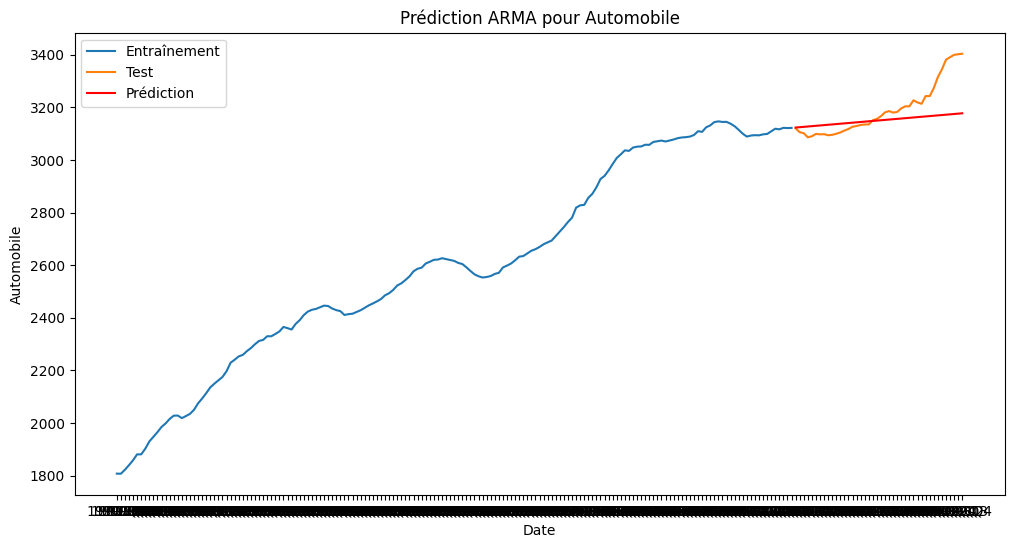

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  167
Model:               SARIMAX(3, 1, 2)   Log Likelihood                -234.125
Date:                Tue, 11 Apr 2023   AIC                            482.251
Time:                        00:49:55   BIC                            504.035
Sample:                    10-01-1970   HQIC                           491.093
                         - 04-01-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0705      0.037      1.885      0.059      -0.003       0.144
ar.L1          2.2751      0.104     21.888      0.000       2.071       2.479
ar.L2         -2.0235      0.174    -11.612      0.0

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


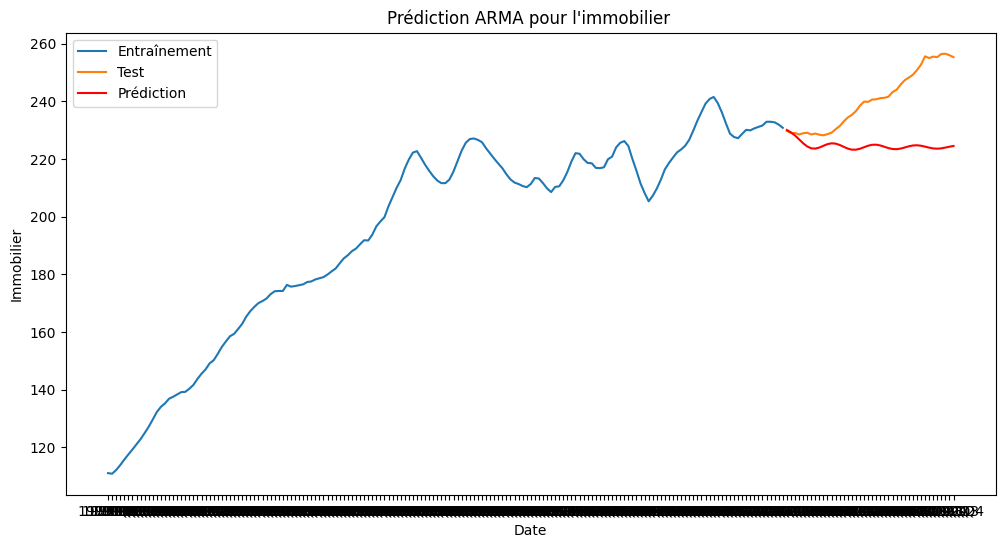

In [ ]:
### Question 5)
## Pour les CDI

# On sépare les données
train_size = int(len(df2_CDI_prediction) * 0.8)
train = df2_CDI_prediction[:train_size]
test = df2_CDI_prediction[train_size:]

# Récupération des meilleurs paramètres
best_fit = auto_arima(train['DPAE (brut)'], suppress_warnings=True, seasonal=False, stepwise=True)
print(best_fit.summary())

# On ajuste le modèle
p, d, q = best_fit.order
model = ARIMA(train['DPAE (brut)'], order=(p, d, q))
model_fit = model.fit()

# On effectue les prédictions
predictions = model_fit.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)

# Visualisation des résultats
plt.plot(train.index, train['DPAE (brut)'], label='Entraînement')
plt.plot(test.index, test['DPAE (brut)'], label='Test')
plt.plot(test.index, predictions, label='Prédiction', color='red')
plt.xlabel('Date')
plt.ylabel('DPAE (brut)')
plt.title('Prédiction ARMA pour DPAE (brut) (CDI)')
plt.legend()
plt.show()

## Pour les CDD

# On sépare les données
train_size = int(len(df2_CDD_prediction) * 0.8)
train = df2_CDD_prediction[:train_size]
test = df2_CDD_prediction[train_size:]

# Récupération des meilleurs paramètres
best_fit = auto_arima(train['DPAE (brut)'], suppress_warnings=True, seasonal=False, stepwise=True)
print(best_fit.summary())

# On ajuste le modèle
p, d, q = best_fit.order
model = ARIMA(train['DPAE (brut)'], order=(p, d, q))
model_fit = model.fit()

# On effectue les prédictions
predictions = model_fit.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)

# Visualisation des résultats
plt.plot(train.index, train['DPAE (brut)'], label='Entraînement')
plt.plot(test.index, test['DPAE (brut)'], label='Test')
plt.plot(test.index, predictions, label='Prédiction', color='red')
plt.xlabel('Date')
plt.ylabel('DPAE (brut)')
plt.title('Prédiction ARMA pour DPAE (brut) (CDD)')
plt.legend()
plt.show()

## Pour ESSA, domaine automobile
df_ESSA_five_series_prediction_automobile = df_ESSA_five_series_prediction.loc[:, ['Automobile']]

# On sépare les données
train_size = int(len(df_ESSA_five_series_prediction) * 0.8)
train = df_ESSA_five_series_prediction[:train_size]
test = df_ESSA_five_series_prediction[train_size:]

# Récupération des meilleurs paramètres
best_fit = auto_arima(train['Automobile'], suppress_warnings=True, seasonal=False, stepwise=True)
print(best_fit.summary())

# On ajuste le modèle
p, d, q = best_fit.order
model = ARIMA(train['Automobile'], order=(p, d, q))
model_fit = model.fit()

# On effectue les prédictions
predictions = model_fit.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)

# Visualisation des résultats
plt.plot(train.index, train['Automobile'], label='Entraînement')
plt.plot(test.index, test['Automobile'], label='Test')
plt.plot(test.index, predictions, label='Prédiction', color='red')
plt.xlabel('Date')
plt.ylabel('Automobile')
plt.title('Prédiction ARMA pour Automobile')
plt.legend()
plt.show()

## Pour ESSA, domaine immobilier
df_ESSA_five_series_prediction_immobilier = df_ESSA_five_series_prediction.loc[:, ['Immobilier']]

# On sépare les données
train_size = int(len(df_ESSA_five_series_prediction_immobilier) * 0.8)
train = df_ESSA_five_series_prediction_immobilier[:train_size]
test = df_ESSA_five_series_prediction_immobilier[train_size:]

# Récupération des meilleurs paramètres
best_fit = auto_arima(train['Immobilier'], suppress_warnings=True, seasonal=False, stepwise=True)
print(best_fit.summary())

# On ajuste le modèle
p, d, q = best_fit.order
model = ARIMA(train['Immobilier'], order=(p, d, q))
model_fit = model.fit()

# On effectue les prédictions
predictions = model_fit.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)

# Visualisation des résultats
plt.plot(train.index, train['Immobilier'], label='Entraînement')
plt.plot(test.index, test['Immobilier'], label='Test')
plt.plot(test.index, predictions, label='Prédiction', color='red')
plt.xlabel('Date')
plt.ylabel('Immobilier')
plt.title("Prédiction ARMA pour l'immobilier ")
plt.legend()
plt.show()





In [ ]:
## Comparaison des résultats
# Naturellement la prédiction par lissage exponentiel simple est constante et n'aboutit pas à une grande précision.
# Les prédictions récupérées avec les méthodes ARMA sont plus efficaces d'après nos graphes autant pour les contrats CDD et CDI que pour les secteurs choisis.
# Toutefois on note que la prédiction via la méthode ARMA pour les contrats CDI nous affiche une valeur constante inexpliquée de notre côté après quelques prédictions.